
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Assignment 3 <br>
</div>


---



### Full Name : mohamad Hosein Mehdikhani
### Student Number : 400102039
___

In [21]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Divide image into 8x8 blocks and apply DCT
## (use realimage.jpg)

In [1]:
import numpy as np
from scipy.fftpack import dct

def apply_dct(image, block_size=8):

    height, width = image.shape

    if height % block_size != 0 or width % block_size != 0:
        raise ValueError("ابعاد تصویر باید مضربی از block_size باشد")


    blocks_h = height // block_size
    blocks_w = width // block_size


    dct_blocks = np.zeros((blocks_h, blocks_w, block_size, block_size))


    for i in range(blocks_h):
        for j in range(blocks_w):

            block = image[i*block_size:(i+1)*block_size,
                         j*block_size:(j+1)*block_size]


            block = block.astype(np.float32) - 128


            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

            dct_blocks[i, j] = dct_block

    return dct_blocks

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dct_blocks(dct_blocks):
    """
    نمایش بصری بلوک‌های DCT
    :param dct_blocks: بلوک‌های DCT خروجی از تابع apply_dct
    """
    blocks_h, blocks_w, block_size, _ = dct_blocks.shape


    vis_image = np.zeros((blocks_h * block_size, blocks_w * block_size))

    for i in range(blocks_h):
        for j in range(blocks_w):

            dct_block = dct_blocks[i, j]


            log_block = np.log(np.abs(dct_block) + 1e-10)  # +1e-10 برای جلوگیری از log(0)


            norm_block = (log_block - np.min(log_block)) / (np.max(log_block) - np.min(log_block)) * 255


            vis_image[i*block_size:(i+1)*block_size,
                      j*block_size:(j+1)*block_size] = norm_block

    plt.figure(figsize=(10, 10))
    plt.imshow(vis_image, cmap='gray')
    plt.title('Visualization of DCT Blocks (Log Scale)')
    plt.axis('off')
    plt.show()




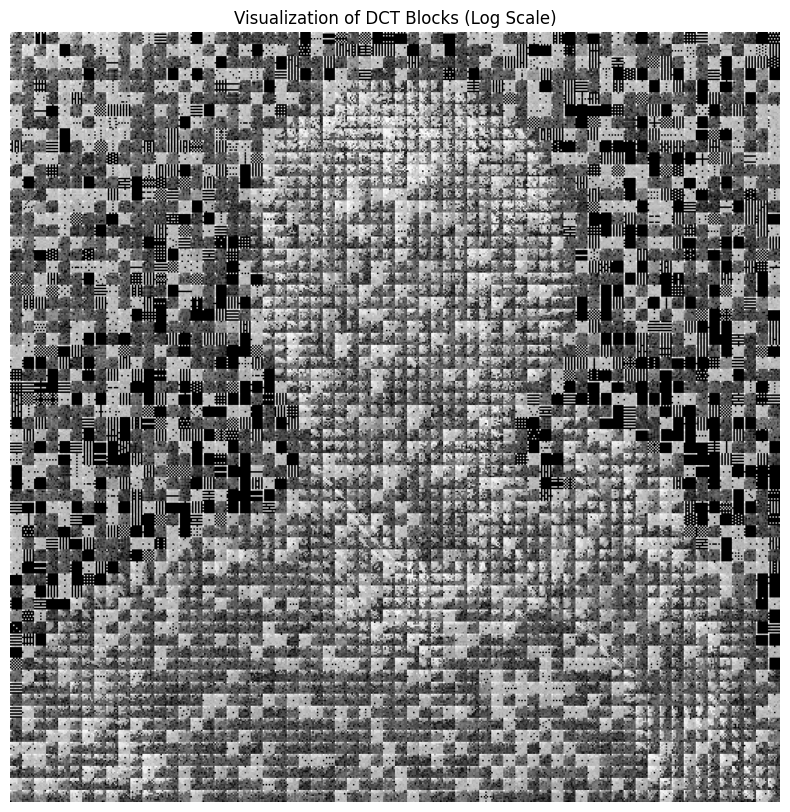

In [7]:
from skimage import io, color


image = io.imread('realImage.jpg')
if len(image.shape) == 3:
    image = color.rgb2gray(image) * 255


dct_blocks = apply_dct(image.astype(np.uint8))
visualize_dct_blocks(dct_blocks)

## Step 2: Quantization


In [9]:
# Quantization matrix

Z = np.array([[16,11,10,16,24,40,51,61],
              [12,12,14,19,26,58,60,55],
              [14,13,16,24,40,57,69,56],
              [14,17,22,29,51,87,80,62],
              [18,22,37,56,68,109,103,77],
              [24,35,55,64,81,104,113,92],
              [49,64,78,87,103,121,120,101],
              [72,92,95,98,112,100,130,99]])

In [10]:
import numpy as np

def quantize(dct_blocks, quantization_matrix=Z):

    quantized_blocks = np.zeros_like(dct_blocks)
    blocks_h, blocks_w, block_size, _ = dct_blocks.shape

    for i in range(blocks_h):
        for j in range(blocks_w):

            quantized_blocks[i,j] = np.round(dct_blocks[i,j] / quantization_matrix)

    return quantized_blocks

In [16]:
quantized_block = quantize(dct_blocks)

### Matrix to vector
Now you need to convert the matrix to an array like this:

`[-17, 0, -19, ..., 'EOB']`

In [11]:
import numpy as np

def mat_2_vec(jpeg_matrix):

    zigzag_order = [
        0, 1, 8, 16, 9, 2, 3, 10,
        17, 24, 32, 25, 18, 11, 4, 5,
        12, 19, 26, 33, 40, 48, 41, 34,
        27, 20, 13, 6, 7, 14, 21, 28,
        35, 42, 49, 56, 57, 50, 43, 36,
        29, 22, 15, 23, 30, 37, 44, 51,
        58, 59, 52, 45, 38, 31, 39, 46,
        53, 60, 61, 54, 47, 55, 62, 63
    ]


    flat_block = jpeg_matrix.flatten()
    zigzag_vector = flat_block[zigzag_order]


    last_non_zero = len(zigzag_vector) - 1
    while last_non_zero >= 0 and zigzag_vector[last_non_zero] == 0:
        last_non_zero -= 1


    if last_non_zero < 0:
        jpeg_vector = ['EOB']
    else:
        jpeg_vector = list(zigzag_vector[:last_non_zero + 1]) + ['EOB']

    return jpeg_vector

In [17]:

compressed_vector = mat_2_vec(quantized_block)
print(compressed_vector)


[np.float64(-1.0), 'EOB']


## Step 3: Apply Inverse DCT for decompression

In [14]:
import numpy as np
from scipy.fftpack import idct
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def apply_idct(quantized_blocks, quantization_matrix=Z):

    blocks_h, blocks_w, block_size, _ = quantized_blocks.shape
    decompressed_image = np.zeros((blocks_h * block_size, blocks_w * block_size))

    for i in range(blocks_h):
        for j in range(blocks_w):

            dct_block = quantized_blocks[i,j] * quantization_matrix


            idct_block = idct(idct(dct_block.T, norm='ortho').T, norm='ortho')


            idct_block = idct_block + 128
            idct_block = np.clip(idct_block, 0, 255)

            decompressed_image[i*block_size:(i+1)*block_size,
                              j*block_size:(j+1)*block_size] = idct_block

    return decompressed_image.astype(np.uint8)

def calculate_metrics(original, decompressed):

    mse = mean_squared_error(original, decompressed)
    psnr = peak_signal_noise_ratio(original, decompressed)
    ssim = structural_similarity(original, decompressed, data_range=255)

    return {
        'MSE': mse,
        'PSNR': psnr,
        'SSIM': ssim
    }

def calculate_compression_rate(original_image, compressed_vector):


    original_size = original_image.size * 8


    compressed_size = len(compressed_vector) * 16


    compression_rate = original_size / compressed_size

    return compression_rate

In [20]:
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def calculate_metrics(original, decompressed):
    # تبدیل تصاویر به float64 و اطمینان از محدوده [0,255]
    original = original.astype(np.float64)
    decompressed = decompressed.astype(np.float64)


    mse = mean_squared_error(original, decompressed)
    psnr = peak_signal_noise_ratio(original, decompressed, data_range=255)
    ssim = structural_similarity(original, decompressed, data_range=255)

    return {
        'MSE': mse,
        'PSNR': psnr,
        'SSIM': ssim
    }

# 1. بازیابی تصویر
decompressed_img = apply_idct(quantized_block)

# 2. اطمینان از محدوده صحیح مقادیر
decompressed_img = np.clip(decompressed_img, 0, 255).astype(np.uint8)

# 3. محاسبه معیارهای کیفیت
metrics = calculate_metrics(image.astype(np.uint8), decompressed_img)
print("MSE:", metrics['MSE'])
print("PSNR:", metrics['PSNR'])
print("SSIM:", metrics['SSIM'])

#محاسبه نرخ فشرده‌سازی
compression_rate = calculate_compression_rate(image, compressed_vector)
print("نرخ فشرده‌سازی:", compression_rate)

MSE: 16.965137481689453
PSNR: 35.83522977446918
SSIM: 0.9547274234949051
نرخ فشرده‌سازی: 65536.0
